In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import sklearn
import re
import missingno as msno
import mlflow
import mlflow.sklearn
import pickle

from sklearn.metrics import fbeta_score, make_scorer, \
    classification_report, roc_auc_score, accuracy_score, \
    precision_score, recall_score, f1_score, confusion_matrix, \
    roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, \
    cross_validate, train_test_split
from sklearn.impute import SimpleImputer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from yellowbrick.model_selection import LearningCurve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
mlflow.start_run()

<ActiveRun: >

In [3]:
main = pd.read_pickle('main.pkl')
main = main.set_index('SK_ID_CURR')

nan_main = main.isnull().mean() * 100

main_mod = nan_main[nan_main < 20].index
main = main[main_mod]
main

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,91036.455000,273109.365,14222.430,244664.505,91036.455000,273109.365,-599.0,-630.333333,-1891.0,3.0
456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,8086.162192,590289.840,2.700,14571.765,7771.447603,567315.675,-56.0,-992.712329,-72468.0,73.0
456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,23158.991250,185271.930,12640.950,81184.005,23158.991250,185271.930,-33.0,-586.375000,-4691.0,8.0


In [4]:
train = main[~main['TARGET'].isnull()]

test = main[main['TARGET'].isnull()]

## Imputation

Imputation par la médiane pour obtenir un dataset complet

In [5]:
train = train.fillna(train.median())
train

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7.0
456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6.0
456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14.0


Suppression des valeurs aberrantes

In [6]:
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna()
train

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,7492.924286,52450.470,6605.910,12815.010,7492.924286,52450.470,-38.0,-156.285714,-1094.0,7.0
456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,10069.867500,60419.205,10046.880,10074.465,10069.867500,60419.205,-2327.0,-2393.833333,-14363.0,6.0
456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,4399.707857,61595.910,27.270,5575.185,4115.915357,57622.815,-1738.0,-2387.428571,-33424.0,14.0


## Train test split

In [7]:
features_train = train.drop(columns=['TARGET'])
target_train = train['TARGET']

Division du dataset en un train et un test (respectivement 70% et 30% du dataset initial)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features_train.values, target_train.values, test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215241, 507), (92247, 507), (215241,), (92247,))

In [10]:
y_train = y_train.reshape(y_train.shape[0], 1)

y_train.shape

(215241, 1)

Traitement du déséquilibre des classes

In [11]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [12]:
models = [
        #('RandomForest', RandomForestClassifier()),
        ('Dummy_Classifier', DummyClassifier()),
        ('LGBMClassifier', LGBMClassifier()),
        #('XGBoost', XGBClassifier())
    ]

## Pipeline d'entrainement des modèles

Ici, on entraine chacun des modèles à tester sur X_train et y_train, puis on les teste sur X_train et y_train en effectuant les mesures de plusieurs scores de performances (Accuracy, AUC, Temps d'exécution, etc...).

Chaque métrique est évaluée à la fois sur la partie train et la partie test pour repérer des éventuels overfitting.

In [13]:
def score_frame(model_list, features, target):
    scores_list = []
    
    for name, model in model_list:
        pipeline = model
        
        pipeline.fit(X_train, y_train)

        scores = cross_validate(pipeline, features, target, cv=5,
                                scoring=('accuracy', 'recall', 'roc_auc',
                                         'precision', 'f1'), return_train_score=True, return_estimator=True)

        scores_list.append({
            'Modele': name,
            'Fit Time (s)': np.mean(scores['fit_time']),
            'Accuracy Train': np.mean(scores['train_accuracy']),
            'Accuracy Test': np.mean(scores['test_accuracy']),
            'AUC Train': np.mean(scores['train_roc_auc']),
            'AUC Test': np.mean(scores['test_roc_auc']),
            'F1 Train': np.mean(scores['train_f1']),
            'F1 Test': np.mean(scores['test_f1']),
            'Recall Train': np.mean(scores['train_recall']),
            'Recall Test': np.mean(scores['test_recall']),
            'Precision Train': np.mean(scores['train_precision']),
            'Precision Test': np.mean(scores['test_precision']),
        })


    df_score = pd.DataFrame(scores_list)
    df_score = df_score[['Modele', 'Fit Time (s)', 'Accuracy Train',
                         'Accuracy Test', 'AUC Train', 'AUC Test',
                         'F1 Train', 'F1 Test', 'Recall Train',
                         'Recall Test', 'Precision Train',
                         'Precision Test']]

    return df_score

In [14]:
df_score = score_frame(models, X_test, y_test)

C:\Users\Pando\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pando\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pando\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pando\AppData\Roaming\Python\Python39\site-packages\skl

[LightGBM] [Info] Number of positive: 197775, number of negative: 197775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.941285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107584
[LightGBM] [Info] Number of data points in the train set: 395550, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5885, number of negative: 67912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43375
[LightGBM] [Info] Number of data points in the train set: 73797, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079746 -> initscore=-2.445806
[LightGBM] [Info] Start training from score -2.445806
[LightGBM] [Info] Number of positive: 5885, number of 

In [15]:
df_score

,Modele,Fit Time (s),Accuracy Train,Accuracy Test,AUC Train,AUC Test,F1 Train,F1 Test,Recall Train,Recall Test,Precision Train,Precision Test
0,Dummy_Classifier,0.072869,0.920247,0.920247,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,LGBMClassifier,3.782249,0.927846,0.919943,0.904442,0.762991,0.183923,0.061922,0.101978,0.033166,0.938181,0.470232


## Choix du LightGBMClassifier

In [16]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 197775, number of negative: 197775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.940394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107584
[LightGBM] [Info] Number of data points in the train set: 395550, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

### ROC Curve Test

Traçage de la courbe ROC. Plus le score AUC est proche de 1, plus la performance du Classifier est bonne.

In [17]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm.predict(X_test)))

AUC : 0.7705
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84890
         1.0       0.53      0.02      0.04      7357

    accuracy                           0.92     92247
   macro avg       0.73      0.51      0.50     92247
weighted avg       0.89      0.92      0.89     92247



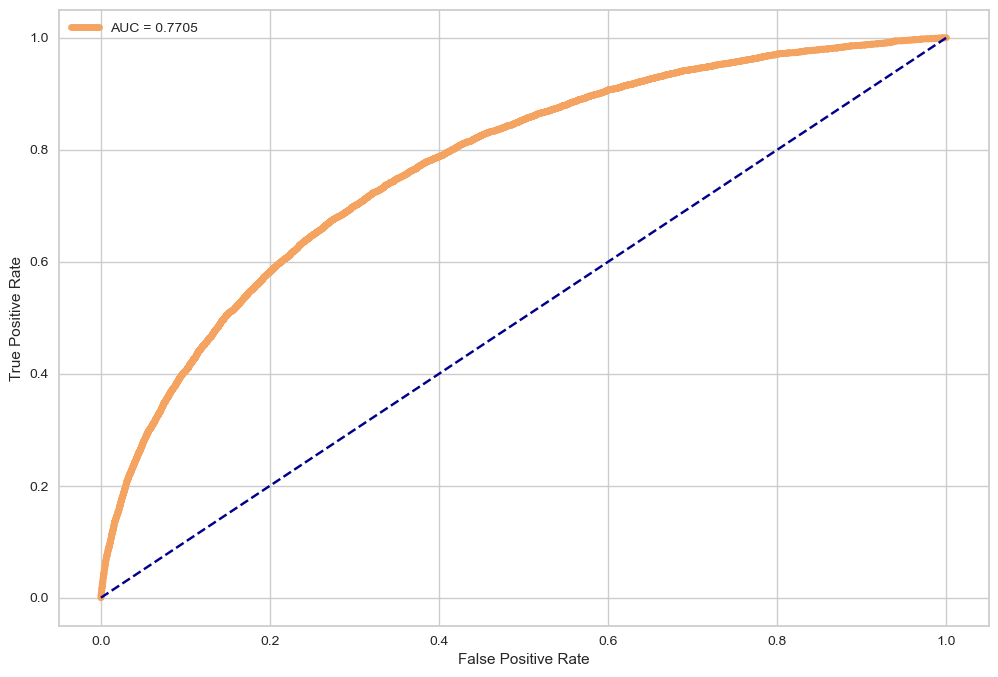

In [18]:
y_predict_test = lgbm.predict_proba(X_test)[:,1]

plt.figure(figsize=(12, 8))
fpr, tpr, _ = roc_curve(y_test, y_predict_test)
plt.plot(fpr, tpr, color='sandybrown', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

Traçage d'une matrice de confusion. Celle-ci permet de déterminer le nombre de cas dans chaque prédiction
(True Positives / Negatives et False Positives / Negatives)

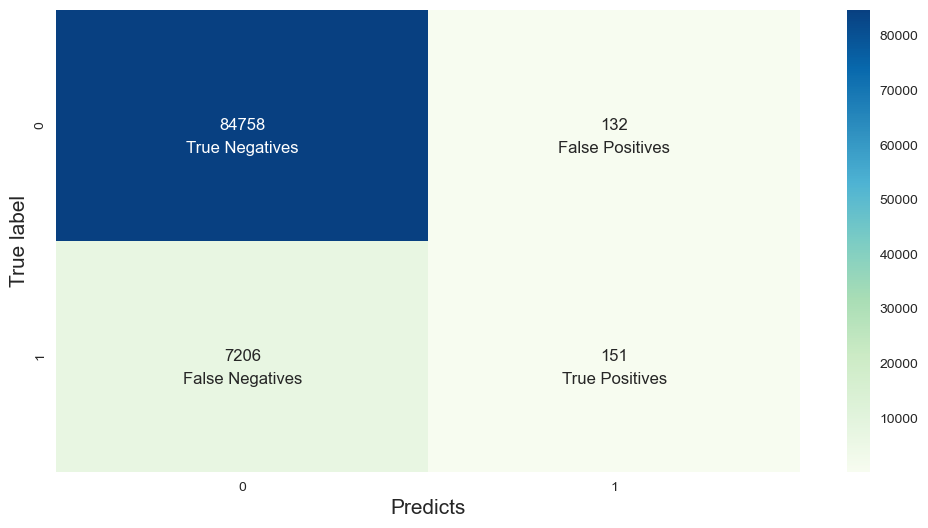

In [19]:
conf_mat = confusion_matrix(y_test, lgbm.predict(X_test))

plt.figure(figsize=(12,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='GnBu')

plt.text(0.5, 0.6, 'True Negatives', ha='center', va='center',
         fontsize=12, color='white')
plt.text(1.5, 0.6, 'False Positives', ha='center', va='center', fontsize=12)
plt.text(0.5, 1.6, 'False Negatives', ha='center', va='center', fontsize=12)
plt.text(1.5, 1.6, 'True Positives', ha='center', va='center', fontsize=12)

plt.xlabel('Predicts', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.show()

In [20]:
def metric(model, beta=3):
    conf_mat = confusion_matrix(y_test, model.predict(X_test))
    
    tn = conf_mat[0, 0]
    tp = conf_mat[1, 1]
    fn = conf_mat[0, 1]
    fp = conf_mat[1, 0]
    
    beta = beta
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    fbeta_score = (1+beta**2)*(precision*recall)/(beta**2*precision + recall)
    print(f'Pour le modèle sélectionné, le score métier est de {fbeta_score : .4f}')

In [21]:
metric(lgbm, beta=3)

Pour le modèle sélectionné, le score métier est de  0.1525


## Feature Importance

In [22]:
import shap
shap.initjs()

explainer = shap.Explainer(lgbm)
feat_imp = explainer.shap_values(features_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Le Feature Importance avec shap permet de connaitre l'impact de chaque feature sur les résultats de la prédiction; il peut-être fait en global (sur la totalité des clients) ou en local (sur un seul client).

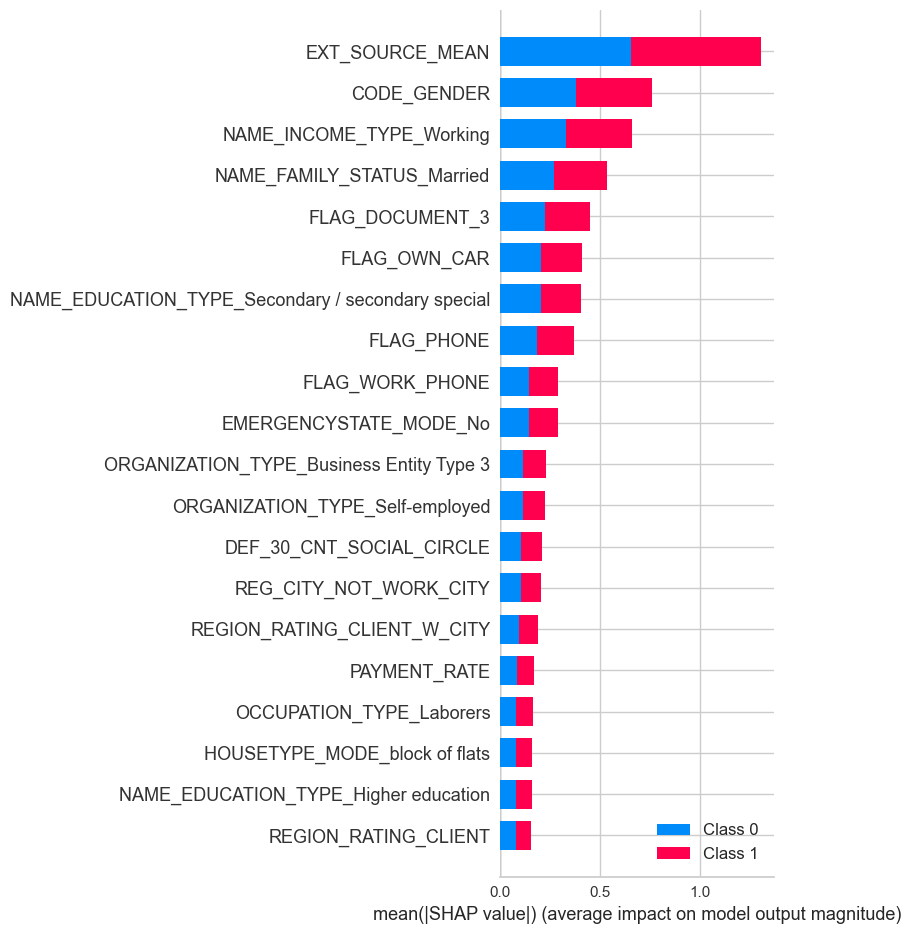

In [23]:
train_col = features_train.columns.tolist()

shap.summary_plot(feat_imp, features_train,
                 feature_names=train_col)

Optimisation des hyperparamètres du modèle choisi.

In [24]:
params = {
    'n_estimators':[25],
    'max_depth':[10],
    'learning_rate':[0.01]
}

gs = GridSearchCV(lgbm, params, scoring='roc_auc', cv=5,
                  n_jobs=-1)

grid = gs.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 197775, number of negative: 197775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.968010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107584
[LightGBM] [Info] Number of data points in the train set: 395550, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [25]:
best_params = grid.best_params_
best_params

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 25}

In [26]:
lgbm_opt = LGBMClassifier(**best_params)
lgbm_opt

LGBMClassifier(learning_rate=0.01, max_depth=10, n_estimators=25)

In [27]:
model_opt = [
        ('LGBM optimized', lgbm_opt)
    ]

In [28]:
score_opt = score_frame(model_opt, X_test, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 197775, number of negative: 197775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.985787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107584
[LightGBM] [Info] Number of data points in the train set: 395550, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of posi

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5885, number of negative: 67912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43380
[LightGBM] [Info] Number of data points in the train set: 73797, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079746 -> initscore=-2.445806
[LightGBM] [Info] Start training from score -2.445806
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5886, number of negative: 67912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43461
[LightGBM] [Info] Number of data points in the train set: 73798, number of used features: 455
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079758 -> initscore=-2.445636
[LightGBM] [Info] Start training from score -2.445636
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5886, number of negative: 67912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43433
[LightGBM] [Info] Number of data points in the train set: 73798, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079758 -> initscore=-2.445636
[LightGBM] [Info] Start training from score -2.445636
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5886, number of negative: 67912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43455
[LightGBM] [Info] Number of data points in the train set: 73798, number of used features: 453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079758 -> initscore=-2.445636
[LightGBM] [Info] Start training from score -2.445636
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [29]:
score_opt

,Modele,Fit Time (s),Accuracy Train,Accuracy Test,AUC Train,AUC Test,F1 Train,F1 Test,Recall Train,Recall Test,Precision Train,Precision Test
0,LGBM optimized,2.05685,0.920247,0.920247,0.743416,0.726437,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
lgbm_opt.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, lgbm_opt.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_opt.predict(X_test)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 197775, number of negative: 197775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.939732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107584
[LightGBM] [Info] Number of data points in the train set: 395550, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.6985
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              preci

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


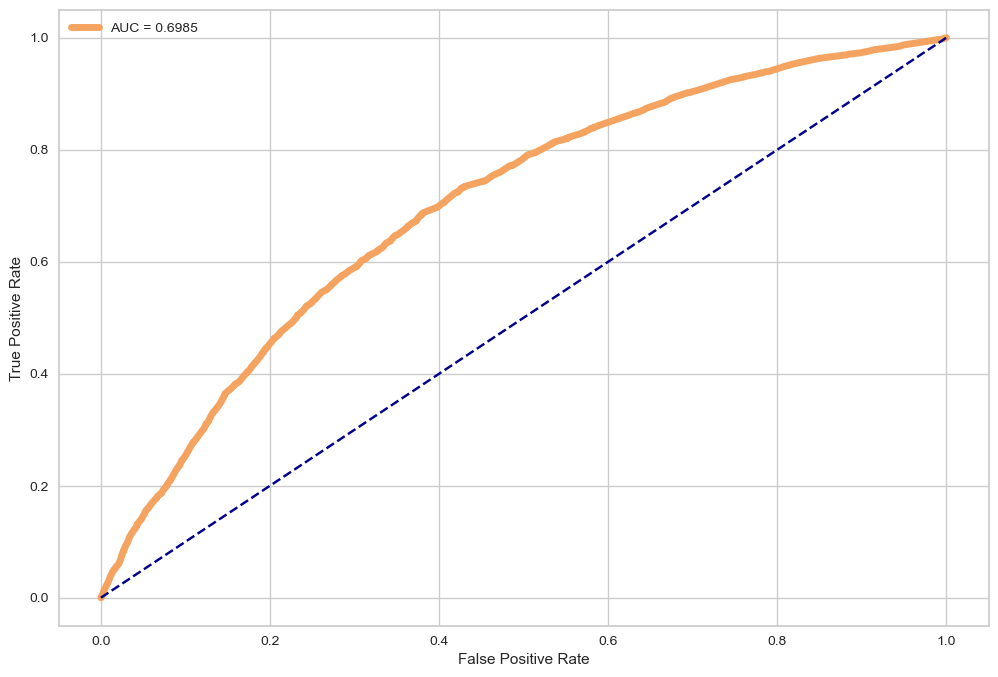

In [31]:
y_opt_predict = lgbm_opt.predict_proba(X_test)[:,1]

plt.figure(figsize=(12, 8))
fpr, tpr, _ = roc_curve(y_test, y_opt_predict)
plt.plot(fpr, tpr, color='sandybrown', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


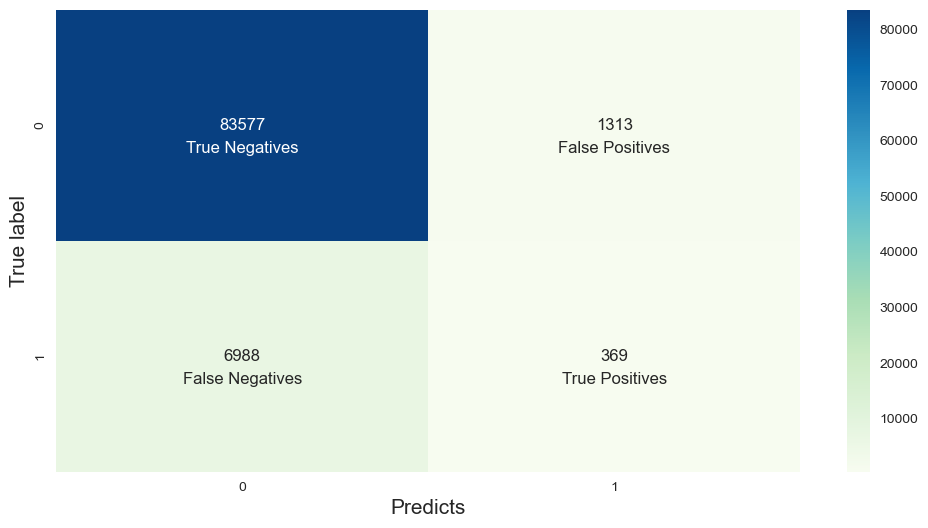

In [32]:
conf_mat_opt = confusion_matrix(y_test, lgbm_opt.predict(X_test))

plt.figure(figsize=(12,6))
sns.heatmap(conf_mat_opt, annot=True, fmt='d', cmap='GnBu')

plt.text(0.5, 0.6, 'True Negatives', ha='center', va='center',
         fontsize=12, color='white')
plt.text(1.5, 0.6, 'False Positives', ha='center', va='center', fontsize=12)
plt.text(0.5, 1.6, 'False Negatives', ha='center', va='center', fontsize=12)
plt.text(1.5, 1.6, 'True Positives', ha='center', va='center', fontsize=12)

plt.xlabel('Predicts', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.show()

In [33]:
metric(lgbm_opt, beta=3)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Pour le modèle sélectionné, le score métier est de  0.1640


## MLFlow

In [34]:
y_true = y_test
y_pred = lgbm_opt.predict(X_test)

fbeta = fbeta_score(y_true, y_pred, beta=3)

mlflow.log_metric("accuracy", accuracy_score(y_true, y_pred))
mlflow.log_metric("precision", precision_score(y_true, y_pred))
mlflow.log_metric("recall", recall_score(y_true, y_pred))
mlflow.log_metric("roc_auc", roc_auc_score(y_true, y_pred))
mlflow.log_metric("f-beta", fbeta)

mlflow.sklearn.log_model(lgbm_opt, "model")

mlflow.end_run()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Setuptools is replacing distutils.


## Conception des Dataframes pour la partie Déploiement

On sélectionne toutes les lignes où les clients n'ont pas reçu de prédiction, puis on récupère un échantillon de 80 clients.
On retire ensuite la colonne 'TARGET' et on sauvegarde au format '.csv'.

In [35]:
test_api = test[test.isnull().sum(axis=1) == 1]
test_api = test_api.sample(n=80, random_state=42)

test_api.index = test_api.index.astype(str)

test_api = test_api.drop('TARGET', axis = 1)

test_api.to_csv('test_api.csv')

In [36]:
test = test.drop('TARGET', axis=1)
test = test.sample(frac=0.9, random_state=42)

test.to_csv('main_test.csv')

In [37]:
application_test = pd.read_csv('application_test.csv')
application_test = application_test.set_index('SK_ID_CURR')

Récupération de la colonne 'NAME_INCOME_TYPE' pour les 80 clients sélectionnés précédemment (valeurs non numériques)

In [38]:
str_api = application_test[['CODE_GENDER', 'NAME_INCOME_TYPE']]
str_api

,CODE_GENDER,NAME_INCOME_TYPE
SK_ID_CURR,,
100001,F,Working
100005,M,Working
100013,M,Working
100028,F,Working
100038,M,Working
...,...,...
456221,F,Working
456222,F,Commercial associate
456223,F,Commercial associate


In [39]:
test_api_index = test_api.index.astype(str)

str_api.index = str_api.index.astype(str)
str_api = str_api.loc[test_api_index]

In [40]:
str_api.to_csv('str_api.csv')

In [41]:
test_index = test.index.astype(str)

application_test.index = application_test.index.astype(str)
pie_test = application_test.loc[test_index]

pie_test.to_csv('pie_test.csv')